In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from model import HoloConfig, HoloForCausalLM

In [2]:
size = 'small'
small_n_config = HoloConfig.from_preset(size, use_version = 1)
small_t_config = HoloConfig.from_preset(size, use_version = 2)

model_n = HoloForCausalLM(small_n_config)
model_t = HoloForCausalLM(small_t_config)

Initializing models...

Starting Inference Benchmark (Batch Size: 1)

Testing Sequence Length: 512
  -> Version 1 (Naive/Eager): 21.09 ms | 24281.69 tok/s
  -> Version 2 (Triton Fused): 19.45 ms | 26326.46 tok/s

Testing Sequence Length: 1024
  -> Version 1 (Naive/Eager): 40.71 ms | 25154.86 tok/s
  -> Version 2 (Triton Fused): 37.76 ms | 27120.26 tok/s

Testing Sequence Length: 2048
  -> Version 1 (Naive/Eager): 80.22 ms | 25529.12 tok/s
  -> Version 2 (Triton Fused): 75.17 ms | 27246.66 tok/s

Testing Sequence Length: 4096
  -> Version 1 (Naive/Eager): 158.97 ms | 25766.36 tok/s
  -> Version 2 (Triton Fused): 147.83 ms | 27707.70 tok/s

Testing Sequence Length: 8192
  -> Version 1 (Naive/Eager): 315.63 ms | 25954.24 tok/s
  -> Version 2 (Triton Fused): 295.45 ms | 27727.06 tok/s

Results Summary:
                      Model  Seq_Len  Latency (ms)  Throughput (tok/s)
0   Version 1 (Naive/Eager)      512     21.085849        24281.687687
1  Version 2 (Triton Fused)      512     19.4481

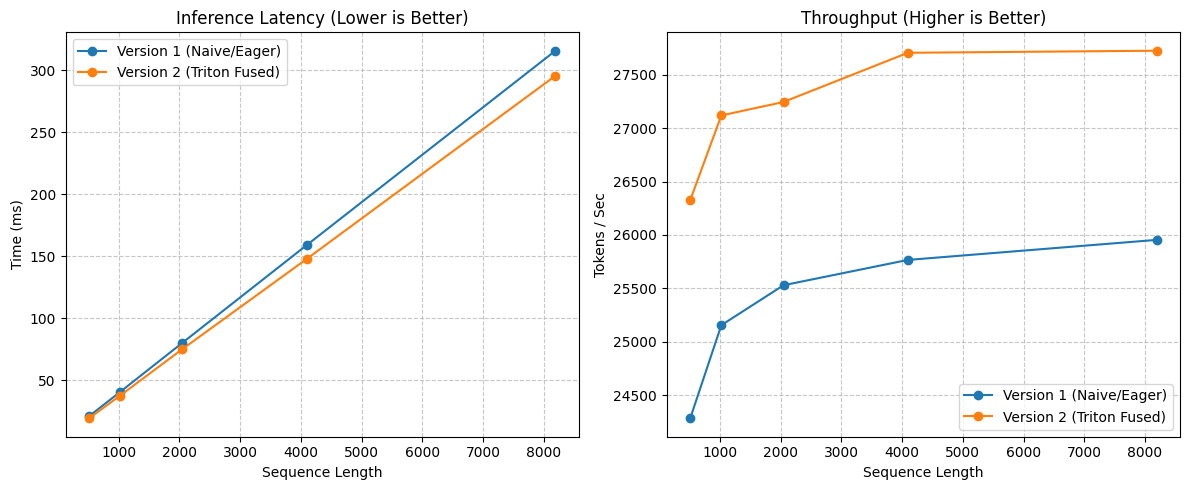

In [5]:
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd
import gc

# ==========================================
# 1. Setup Models (User provided code)
# ==========================================
# Assuming HoloConfig and HoloForCausalLM are imported
# from holo_gpt.config import HoloConfig
# from holo_gpt.model import HoloForCausalLM

print("Initializing models...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

size = 'small'
small_n_config = HoloConfig.from_preset(size, use_version = 1)
small_t_config = HoloConfig.from_preset(size, use_version = 2)

model_n = HoloForCausalLM(small_n_config)
model_t = HoloForCausalLM(small_t_config)

# (Mocking the models for the script logic - UNCOMMENT YOUR ACTUAL IMPORTS ABOVE)
# Ensure your models are moved to .to(device) and .eval()
model_n = model_n.to(device).eval()
model_t = model_t.to(device).eval()

# ==========================================
# 2. The Benchmark Function
# ==========================================

def run_inference_benchmark(
    models_dict, 
    seq_lens=[512, 1024, 2048, 4096, 8192], 
    batch_size=1, 
    warmup=5, 
    repetitions=20
):
    results = []
    
    print(f"\n{'='*60}")
    print(f"Starting Inference Benchmark (Batch Size: {batch_size})")
    print(f"{'='*60}")

    for seq_len in seq_lens:
        print(f"\nTesting Sequence Length: {seq_len}")
        
        # Create dummy input
        # Note: We use high values to ensure no embedding index errors
        input_ids = torch.randint(0, 1000, (batch_size, seq_len), device=device)
        
        for name, model in models_dict.items():
            try:
                # 1. Clear Cache to prevent OOM from previous runs affecting this one
                torch.cuda.empty_cache()
                gc.collect()
                
                # 2. Warmup
                # GPU needs to compile kernels and settle clock speeds
                with torch.no_grad():
                    for _ in range(warmup):
                        _ = model(input_ids)
                
                torch.cuda.synchronize() # Wait for warmup to finish
                
                # 3. Measurement
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                
                start_event.record()
                with torch.no_grad():
                    for _ in range(repetitions):
                        _ = model(input_ids)
                end_event.record()
                
                torch.cuda.synchronize() # Wait for all GPU work to finish
                
                # 4. Calculate Stats
                total_time_ms = start_event.elapsed_time(end_event)
                avg_time_ms = total_time_ms / repetitions
                tokens_per_sec = (batch_size * seq_len) / (avg_time_ms / 1000)
                
                print(f"  -> {name}: {avg_time_ms:.2f} ms | {tokens_per_sec:.2f} tok/s")
                
                results.append({
                    "Model": name,
                    "Seq_Len": seq_len,
                    "Latency (ms)": avg_time_ms,
                    "Throughput (tok/s)": tokens_per_sec
                })
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"  -> {name}: OOM (Out of Memory)")
                    results.append({
                        "Model": name,
                        "Seq_Len": seq_len,
                        "Latency (ms)": None,
                        "Throughput (tok/s)": 0
                    })
                    torch.cuda.empty_cache()
                else:
                    raise e

    return pd.DataFrame(results)

# ==========================================
# 3. Run It
# ==========================================

# Dict of models to test
models_to_test = {
    "Version 1 (Naive/Eager)": model_n,
    "Version 2 (Triton Fused)": model_t
}

# Run benchmark
# Note: Ensure your GPU has enough VRAM for 8192. 
# If OOM, reduce batch_size to 1 or max seq_len.
df_results = run_inference_benchmark(
    models_to_test, 
    seq_lens=[512, 1024, 2048, 4096, 8192], 
    batch_size=1
)

# ==========================================
# 4. Visualization
# ==========================================

def plot_results(df):
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Latency (Lower is better)
    plt.subplot(1, 2, 1)
    for model_name in df['Model'].unique():
        subset = df[df['Model'] == model_name]
        plt.plot(subset['Seq_Len'], subset['Latency (ms)'], marker='o', label=model_name)
    
    plt.title('Inference Latency (Lower is Better)')
    plt.xlabel('Sequence Length')
    plt.ylabel('Time (ms)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend()
    
    # Plot 2: Throughput (Higher is better)
    plt.subplot(1, 2, 2)
    for model_name in df['Model'].unique():
        subset = df[df['Model'] == model_name]
        plt.plot(subset['Seq_Len'], subset['Throughput (tok/s)'], marker='o', label=model_name)
    
    plt.title('Throughput (Higher is Better)')
    plt.xlabel('Sequence Length')
    plt.ylabel('Tokens / Sec')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("\nResults Summary:")
print(df_results)

plot_results(df_results)

### Backward speed

In [ ]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import gc

# ==========================================
# 1. Setup Models (Mock imports for context)
# ==========================================
# Ensure your models are on GPU
# model_n = model_n.cuda().train()
# model_t = model_t.cuda().train()

# ==========================================
# 2. Benchmark Function
# ==========================================

def run_training_benchmark(
    models_dict, 
    seq_lens=[512, 1024, 2048, 4096, 8192], 
    batch_size=1, 
    warmup=3, 
    repetitions=10
):
    results = []
    device = torch.device("cuda")
    
    print(f"\n{'='*80}")
    print(f"TRAINING BENCHMARK (Forward + Backward) | Batch Size: {batch_size}")
    print(f"{'='*80}")

    for seq_len in seq_lens:
        print(f"\n--- Sequence Length: {seq_len} ---")
        
        # Create Data
        input_ids = torch.randint(0, 1000, (batch_size, seq_len), device=device)
        labels = torch.randint(0, 1000, (batch_size, seq_len), device=device)
        
        for name, model in models_dict.items():
            # Reset
            model.zero_grad(set_to_none=True)
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            gc.collect()

            try:
                # 1. Warmup
                # We must run fwd+bwd to compile the backward graph
                for _ in range(warmup):
                    outputs = model(input_ids)
                    loss = outputs.logits.mean() # Dummy loss
                    loss.backward()
                    model.zero_grad(set_to_none=True)
                
                torch.cuda.synchronize()
                
                # 2. Measurement (Time)
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                
                # Reset memory stats again before the timed run to get clean read
                torch.cuda.reset_peak_memory_stats()
                
                start_event.record()
                for _ in range(repetitions):
                    outputs = model(input_ids)
                    loss = outputs.logits.mean()
                    loss.backward()
                    model.zero_grad(set_to_none=True)
                end_event.record()
                
                torch.cuda.synchronize()
                
                # 3. Measurement (Memory)
                peak_mem_bytes = torch.cuda.max_memory_allocated()
                peak_mem_gb = peak_mem_bytes / (1024**3)
                
                # 4. Stats
                total_time_ms = start_event.elapsed_time(end_event)
                avg_time_ms = total_time_ms / repetitions
                tokens_per_sec = (batch_size * seq_len) / (avg_time_ms / 1000)
                
                print(f"  -> {name}: {avg_time_ms:.2f} ms | {tokens_per_sec:.2f} tok/s | Mem: {peak_mem_gb:.2f} GB")
                
                results.append({
                    "Model": name,
                    "Seq_Len": seq_len,
                    "Latency (ms)": avg_time_ms,
                    "Throughput (tok/s)": tokens_per_sec,
                    "Peak Memory (GB)": peak_mem_gb
                })

            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"  -> {name}: ❌ OOM (Out of Memory)")
                    results.append({
                        "Model": name,
                        "Seq_Len": seq_len,
                        "Latency (ms)": None,
                        "Throughput (tok/s)": 0,
                        "Peak Memory (GB)": 0 # Indicate fail
                    })
                    torch.cuda.empty_cache()
                else:
                    print(f"  -> {name}: ❌ Error: {e}")
                    raise e

    return pd.DataFrame(results)

# ==========================================
# 3. Execution
# ==========================================

# Make sure models are in TRAIN mode
model_n.train()
model_t.train()

models_to_test = {
    "Eager (Naive)": model_n,
    "Triton (Fused)": model_t
}

# Run it
df_train = run_training_benchmark(
    models_to_test, 
    seq_lens=[512, 1024, 2048, 4096, 8192], 
    batch_size=1
)

# ==========================================
# 4. Visualization
# ==========================================

def plot_training_results(df):
    plt.figure(figsize=(18, 5))
    
    # Filter out OOMs for plotting lines
    df_clean = df[df['Throughput (tok/s)'] > 0]

    # Plot 1: Time
    plt.subplot(1, 3, 1)
    for name in df['Model'].unique():
        subset = df_clean[df_clean['Model'] == name]
        plt.plot(subset['Seq_Len'], subset['Latency (ms)'], marker='o', label=name)
    plt.title('Training Step Latency (Lower is Better)')
    plt.xlabel('Sequence Length')
    plt.ylabel('Time (ms)')
    plt.grid(True, alpha=0.5)
    plt.legend()
    
    # Plot 2: Memory
    plt.subplot(1, 3, 2)
    for name in df['Model'].unique():
        subset = df_clean[df_clean['Model'] == name]
        plt.plot(subset['Seq_Len'], subset['Peak Memory (GB)'], marker='s', label=name)
    plt.title('Peak VRAM Usage (Lower is Better)')
    plt.xlabel('Sequence Length')
    plt.ylabel('Memory (GB)')
    plt.grid(True, alpha=0.5)
    plt.legend()
    
    # Plot 3: Throughput
    plt.subplot(1, 3, 3)
    for name in df['Model'].unique():
        subset = df_clean[df_clean['Model'] == name]
        plt.plot(subset['Seq_Len'], subset['Throughput (tok/s)'], marker='^', label=name)
    plt.title('Training Throughput (Higher is Better)')
    plt.xlabel('Sequence Length')
    plt.ylabel('Tokens / Sec')
    plt.grid(True, alpha=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("\nFinal Results:")
print(df_train)
plot_training_results(df_train)


TRAINING BENCHMARK (Forward + Backward) | Batch Size: 2

--- Sequence Length: 512 ---
  -> Eager (Naive): 107.42 ms | 9532.86 tok/s | Mem: 4.08 GB
  -> Triton (Fused): 99.69 ms | 10271.80 tok/s | Mem: 4.08 GB

--- Sequence Length: 1024 ---
  -> Eager (Naive): 210.94 ms | 9709.14 tok/s | Mem: 6.65 GB
  -> Triton (Fused): 195.84 ms | 10457.32 tok/s | Mem: 6.65 GB

--- Sequence Length: 2048 ---
  -> Eager (Naive): 413.76 ms | 9899.42 tok/s | Mem: 11.80 GB
  -> Triton (Fused): 388.87 ms | 10533.15 tok/s | Mem: 11.80 GB

--- Sequence Length: 4096 ---
  -> Eager (Naive): ❌ OOM (Out of Memory)
